# Tema 1: Compresia JPEG

In [187]:
import os
import numpy as np
import matplotlib.pyplot as plt

from scipy import datasets as misc
from scipy.fft import dctn, idctn


In [188]:
# The standard quantization matrix following the JPEG standard
Q_table = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 28, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
], dtype=np.float64)

In [189]:
def show_images(images: list, titles: list, cmap: str ='gray', file_name: str = None, fig_title: str = None, img_size=(4, 4)) -> None:
    
    fig, axs = plt.subplots(1, len(images), 
                            figsize=(len(images) * img_size[0], img_size[1]), 
                            constrained_layout=True)

    for i, (img, title) in enumerate(zip(images, titles)):
        axs[i].imshow(img, cmap=cmap)
        axs[i].set_title(title)
        axs[i].axis('off')
        if fig_title:
            fig.suptitle(fig_title)

    if file_name:
        plt.savefig(file_name)

    # plt.tight_layout()
    plt.show()
    plt.close()

# Function that deletes the directory and all its contents
def delete_dir(directory: str) -> None:
    if os.path.exists(directory):
        for file in os.listdir(directory):
            os.remove(os.path.join(directory, file))
        os.rmdir(directory)
    

1. Completați algoritmul JPEG incluzând toate blocurile din imagine.

In [190]:
def compress_2d(X: np.ndarray, Q: np.ndarray, norm='backward') -> np.ndarray:
    """
    Compresses a 2D image using JPEG algorithm.

    Args:
        @param X: Image to be compressed.
        @param Q: Quantization table.
        @param norm: Normalization type. Can be 'forward', 'ortho' or 'backward'.
    
    Returns: 
        Compressed 2D image.
    """

    rows, col = X.shape
    jpeg_image = np.zeros_like(X)

    block_size = Q.shape[0]

    for i in range(0, rows, block_size):
        for j in range(0, col, block_size):
            # Extract the 8x8 block
            block = X[i : i + block_size, j : j + block_size]

            # Apply DCT on the block
            dct_block = dctn(block, norm=norm)

            # Quantize the block
            quantized_block = Q * np.round(dct_block / Q)

            # Apply IDCT on the block
            jpeg_image[i:i+block_size, j:j+block_size] = idctn(quantized_block, norm=norm)

    return jpeg_image

Original image size: 246.68 KB
Compressed image size: 261.42 KB


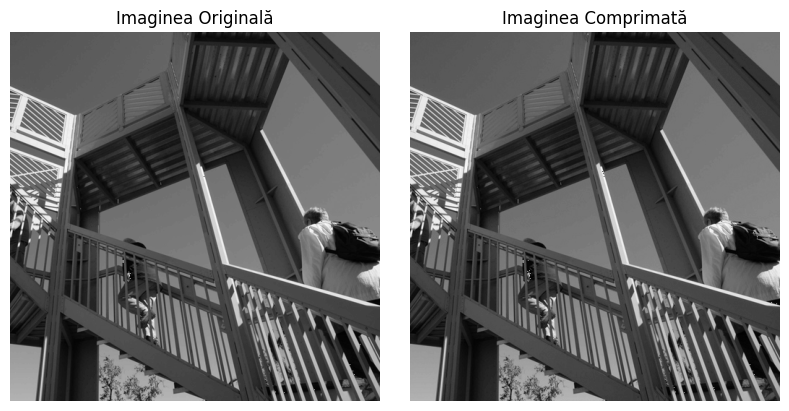

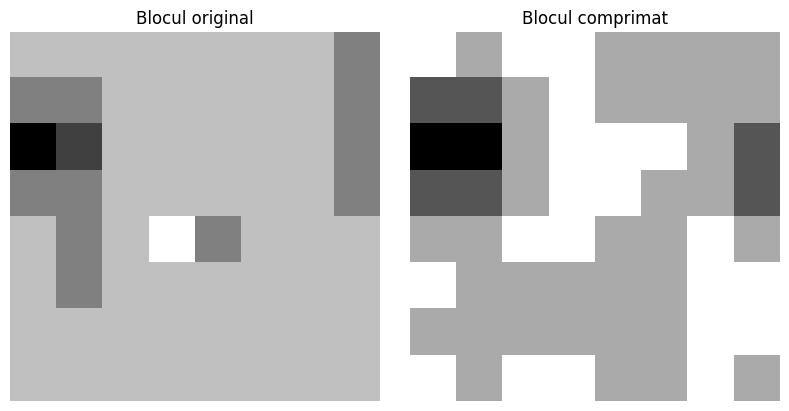

In [191]:
image = misc.ascent()
compressed_image = compress_2d(image, Q_table)

dir_path = '1'
delete_dir(dir_path)
if not os.path.exists(dir_path):
    os.mkdir(dir_path)

# Save the images
plt.imsave(f'{dir_path}/original.png', image, cmap='gray')
plt.imsave(f'{dir_path}/compressed.png', compressed_image, cmap='gray')

# Print the size of the images in KB
print(f"Original image size: {os.path.getsize(f'{dir_path}/original.png') / 1024:.2f} KB")
print(f"Compressed image size: {os.path.getsize(f'{dir_path}/compressed.png') / 1024:.2f} KB")

show_images(
    images=[image, compressed_image], 
    titles=['Imaginea Originală', 'Imaginea Comprimată'], 
    file_name=f'{dir_path}/1.1.pdf'
)

show_images(
    images=[image[:8, :8], compressed_image[:8, :8]],
    titles=['Blocul original', 'Blocul comprimat'],
    file_name=f'{dir_path}/1.2.pdf'
)

2. Extindeți la imagini color (incluzând transformarea din RGB în Y'CbCr). Exemplificați pe `scipy.misc.face` folosită în tema anterioară.

In [192]:
from skimage.color import rgb2ycbcr, ycbcr2rgb

def compress_3d(X: np.ndarray, Q: np.ndarray) -> tuple:    
    """
    Compresses a 3D image using JPEG algorithm using 
    the compress_2d function for each channel of the picture.

    Args:
        @param: X: Image to be compressed.
        @param: Q: Quantization table.
    
    Returns:
        Compressed images in Y'CbCr and RGB space.
    """

    image = rgb2ycbcr(X)
    compressed_ycbcr = np.zeros_like(image)
    
    for channel in range(3):
        compressed_ycbcr[:, :, channel] = compress_2d(image[:, :, channel], Q)
        
    return compressed_ycbcr, ycbcr2rgb(compressed_ycbcr)

Original RGB image size: 1276.49. KB
Compressed Y'CbCr image size: 880.38 KB
Compressed RGB image size: 1403.88 KB


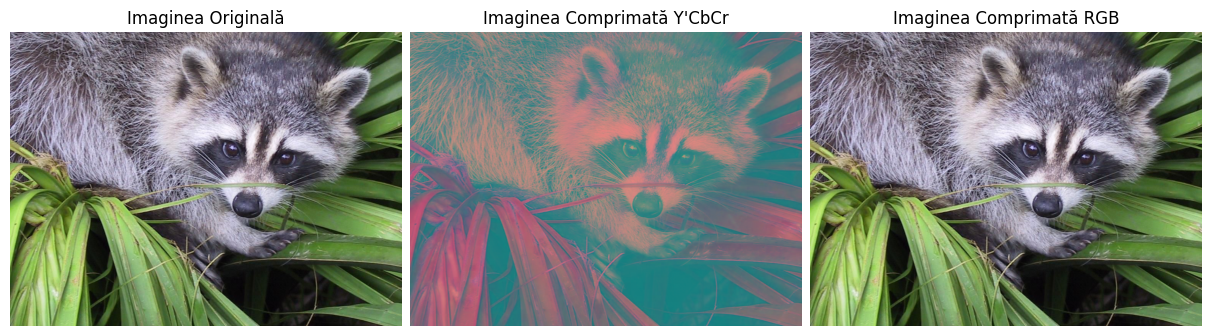

In [193]:
image = misc.face()
compressed_ycbcr, compressed_rgb = compress_3d(image, Q_table)

# Clip values for visualization
ycbcr_img = np.clip(compressed_ycbcr, 0, 255).astype(np.uint8)
rgb_img = np.clip(compressed_rgb, 0, 1)

# Create directory
dir_path = '2'
delete_dir(dir_path)
if not os.path.exists(dir_path):
    os.mkdir(dir_path)

# Save images
plt.imsave(f'{dir_path}/original_image.png', image)
plt.imsave(f'{dir_path}/compressed_ycbcr.png', ycbcr_img)
plt.imsave(f'{dir_path}/compressed_rgb.png', rgb_img)

# Print size in KB
print(f"Original RGB image size: {os.path.getsize(f'{dir_path}/original_image.png') / 1024:.2f}. KB")
print(f"Compressed Y'CbCr image size: {os.path.getsize(f'{dir_path}/compressed_ycbcr.png') / 1024:.2f} KB")
print(f"Compressed RGB image size: {os.path.getsize(f'{dir_path}/compressed_rgb.png') / 1024:.2f} KB")

# Plot images
show_images(
    images=[image, ycbcr_img, rgb_img],
    titles=['Imaginea Originală', 'Imaginea Comprimată Y\'CbCr', 'Imaginea Comprimată RGB'],
    cmap=plt.cm.viridis,
    file_name=f'{dir_path}/2.pdf'
)


3. Extindeți algoritmul pentru compresia imaginii până la un prag MSE impus de utilizator.

In [194]:
from sklearn.metrics import mean_squared_error
from skimage import img_as_float

def compress_image(X: np.ndarray, Q: np.ndarray, mse_treshold: float=0.01, scale_factor: int=25) -> tuple:
    """
    Compresses an image until the MSE is greater than a given treshold.

    Args:
        @param X: Image to be compressed.
        @param Q: Quantization table.
        @param mse_treshold: MSE treshold to stop the compression.
        @param scale_factor: Scale factor to increase the quantization matrix.
    
    Returns:
        Compressed images in Y'CbCr and RGB space.
    """

    mse = 0
    scale = 1

    while mse < mse_treshold:
        # Scale the quantization matrix
        Q_scaled = Q * scale

        # Compress the image with the new quantization matrix
        compressed_ycbcr, compressed_rgb = compress_3d(X, Q_scaled)

        # Compute the MSE between the original and the compressed image
        mse = mean_squared_error(img_as_float(X.flatten()), compressed_rgb.flatten())
        print(f"MSE: {mse}, Scale: {scale}")
        scale += scale_factor
        
    return compressed_ycbcr, compressed_rgb

MSE: 3.897862824867491e-06, Scale: 1
MSE: 0.0018607418860999972, Scale: 101
MSE: 0.0038638848720368695, Scale: 201
MSE: 0.005490288416429484, Scale: 301
MSE: 0.007724016176018551, Scale: 401
MSE: 0.00926852052866069, Scale: 501
MSE: 0.014952551594859226, Scale: 601


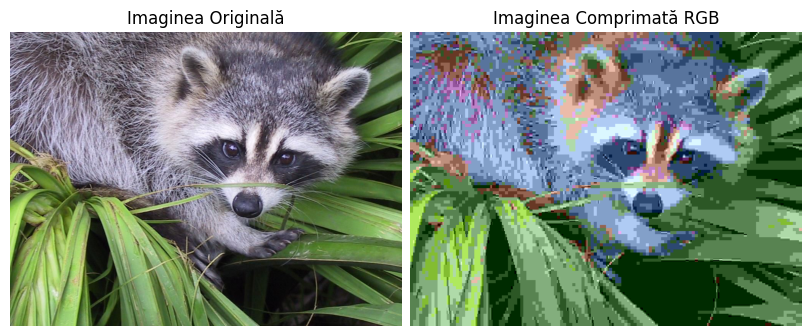

In [195]:
image = misc.face()
compressed_ycbcr, compressed_rgb = compress_image(image, Q_table, mse_treshold=0.01, scale_factor=100)

# Clip values for visualization
ycbcr_img = np.clip(compressed_ycbcr, 0, 255).astype(np.uint8)
rgb_img = np.clip(compressed_rgb, 0, 1)

# Create directory
dir_path = '3'
delete_dir(dir_path)
if not os.path.exists(dir_path):
    os.mkdir(dir_path)

# Save images
plt.imsave(f'{dir_path}/original_image.png', image)
plt.imsave(f'{dir_path}/compressed_ycbcr.png', ycbcr_img)
plt.imsave(f'{dir_path}/compressed_rgb.png', rgb_img)

# Plot images
show_images(
    images=[image, rgb_img],
    titles=['Imaginea Originală', 'Imaginea Comprimată RGB'],
    cmap=plt.cm.viridis,
    file_name=f'{dir_path}/3.pdf'
)

4. Extindeți algoritmul pentru compresie video. Demonstrați pe un clip scurt din care luați fiecare cadru și îl tratați ca pe o imagine.

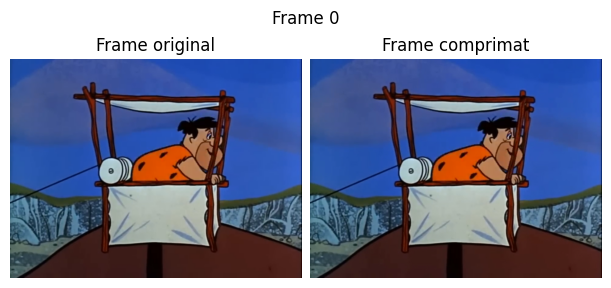

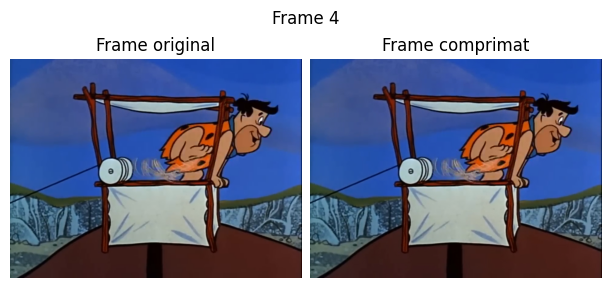

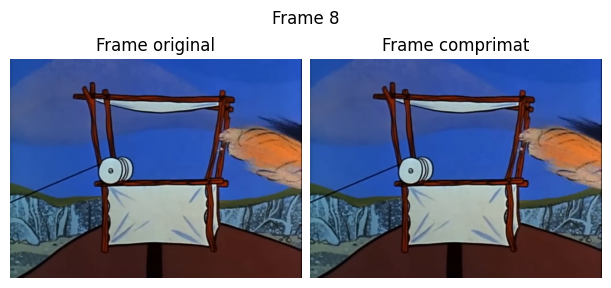

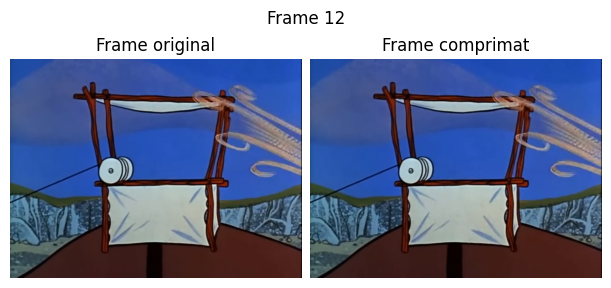

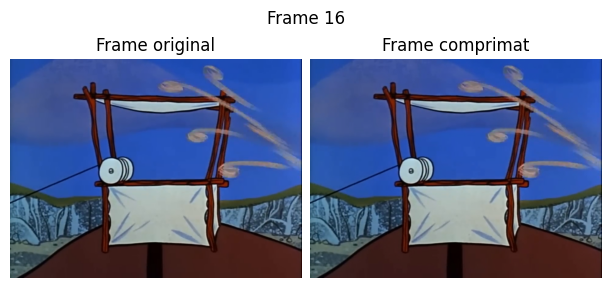

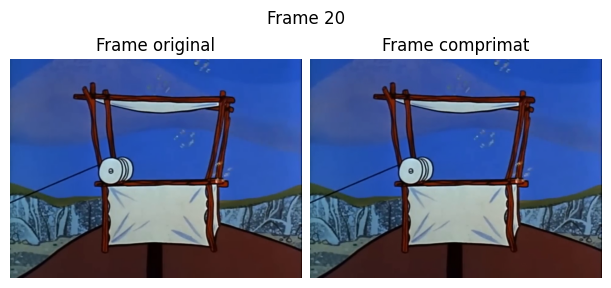

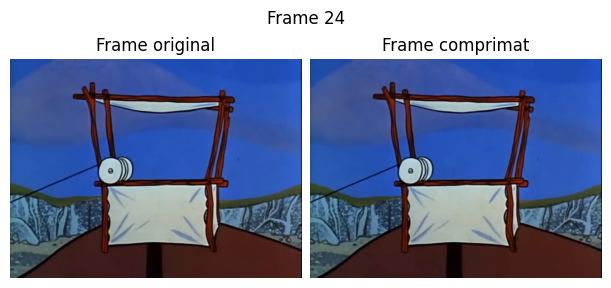

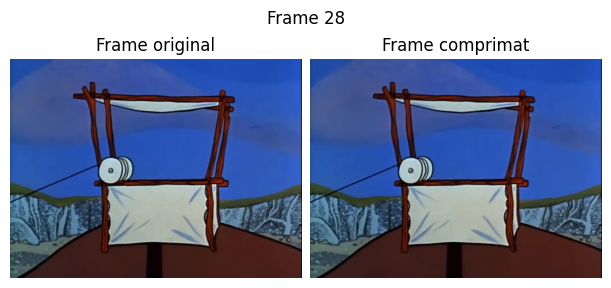

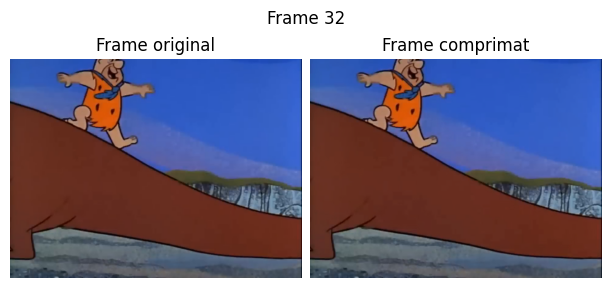

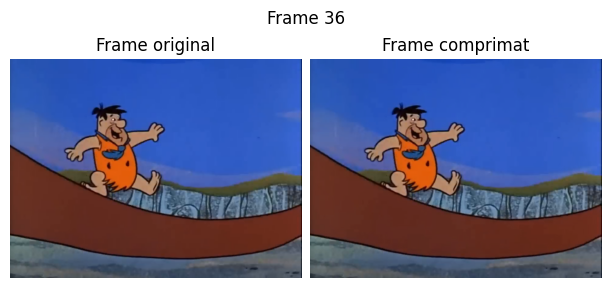

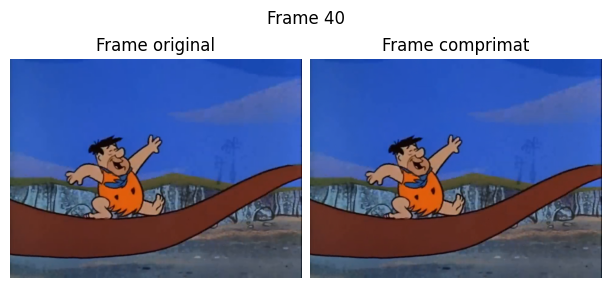

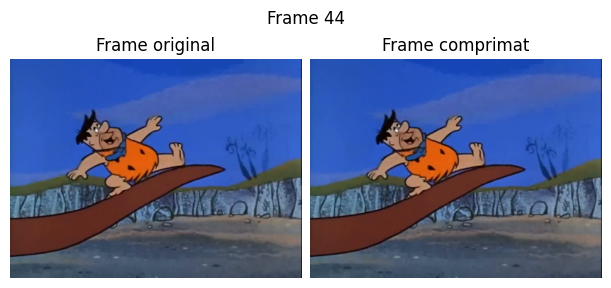

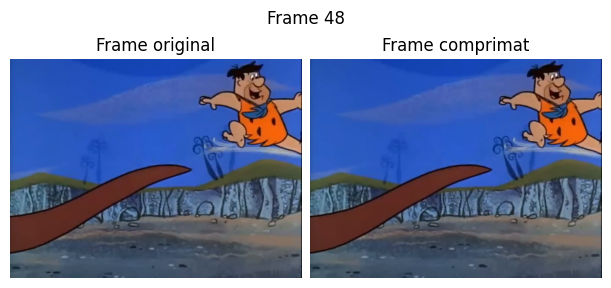

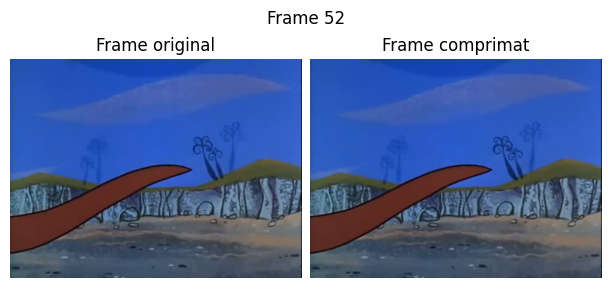

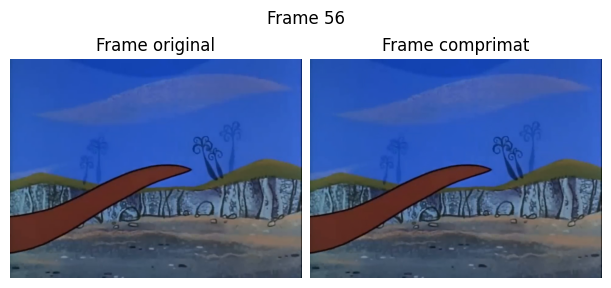

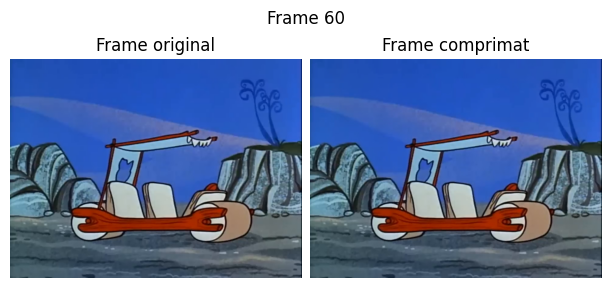

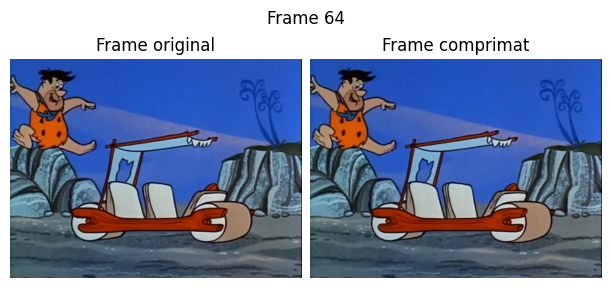

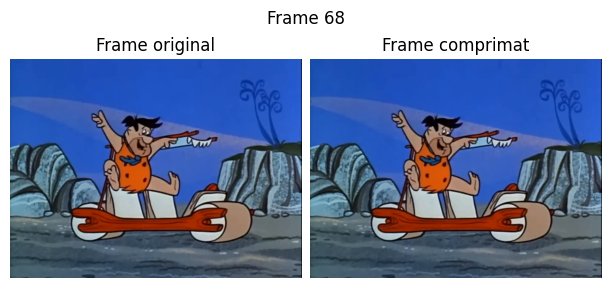

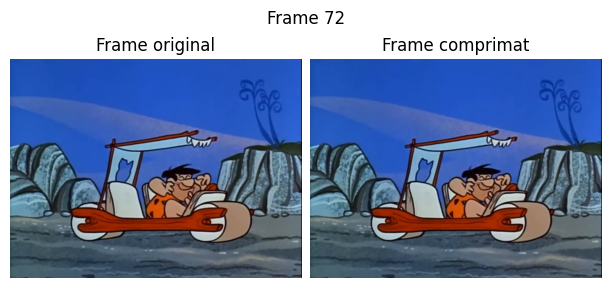

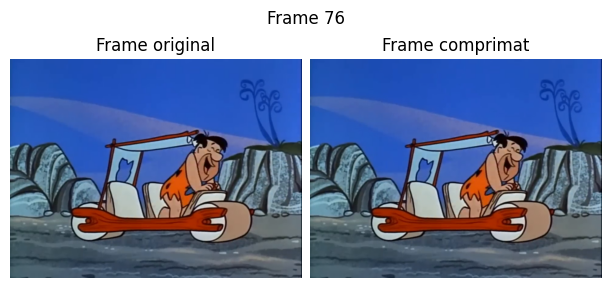

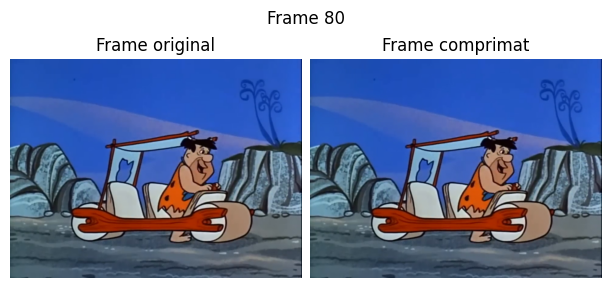

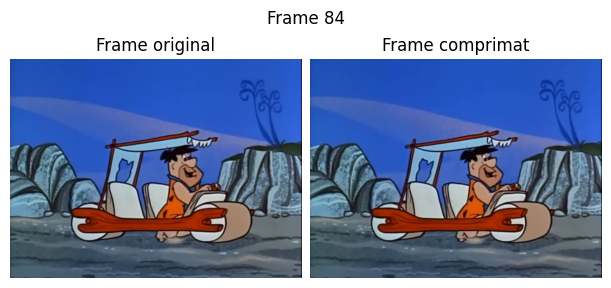

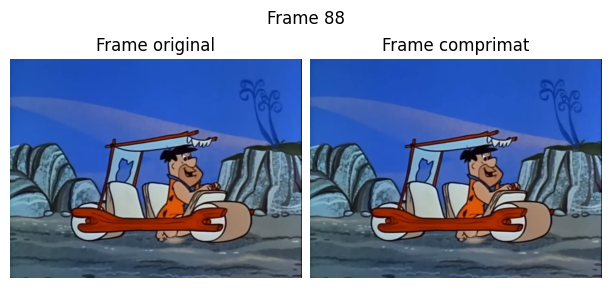

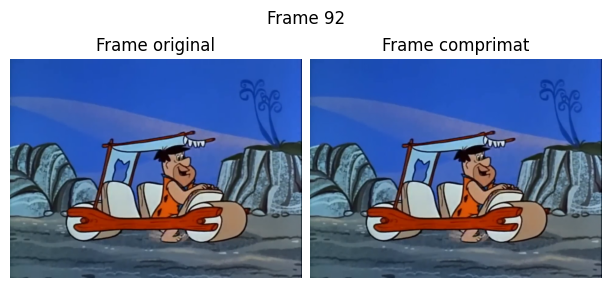

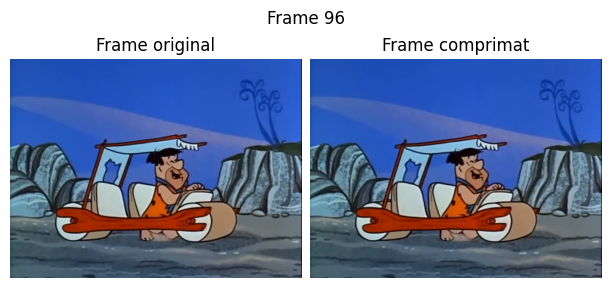

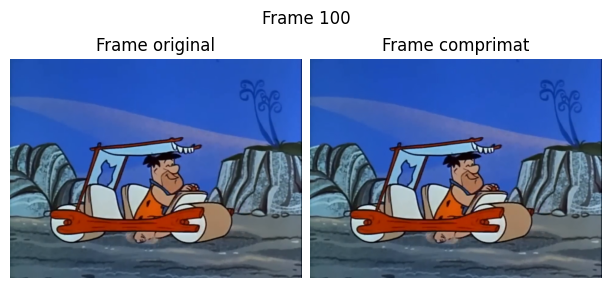

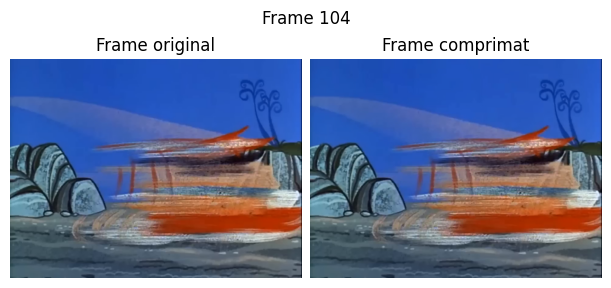

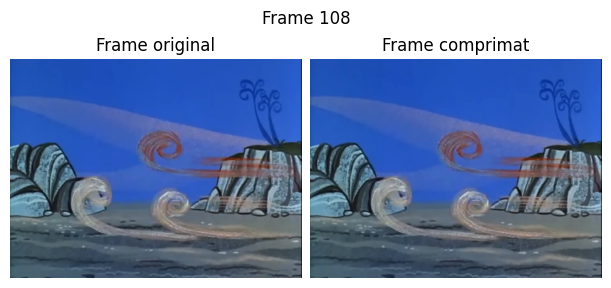

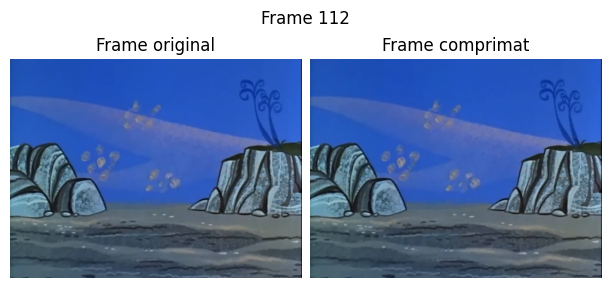

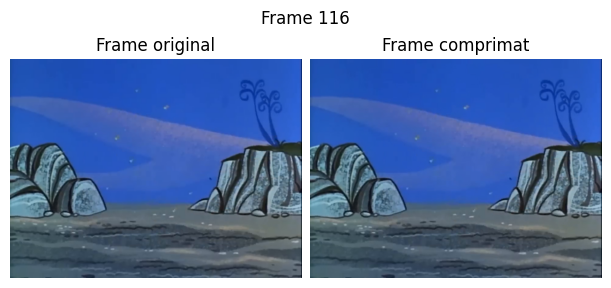

In [197]:
import imageio

# Video of 5 seconds with 24 FPS
video_path = 'video.mp4'
video_reader = imageio.get_reader(video_path)

# Create directory
dir_path = '4'
delete_dir(dir_path)
if not os.path.exists(dir_path):
    os.mkdir(dir_path)

# Number of frames between each compression
frames_between = 4

# Compress every frame of the video 
for i, frame in enumerate(video_reader):

    if i != 0 and i % frames_between :
        continue
    
    # Compress the frame
    _, compressed_frame = compress_3d(frame, Q_table)

    # Clip values for visualization
    compressed_frame = np.clip(compressed_frame, 0, 1)

    show_images(
        images=[frame, compressed_frame],
        titles=['Frame original', 'Frame comprimat'],
        cmap=plt.cm.viridis,
        file_name=f'{dir_path}/frame_{i}.pdf',
        fig_title=f'Frame {i}',
        img_size=(3, 3)
    )
